**Univariate linear regression**

In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import scipy.stats as stats
from scipy import stats

In [3]:
# Initial data
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Augmenting data by replicating and adding noise
np.random.seed(42)
augmented = []
for i in range(len(df)):
    row = df.iloc[i]
    for _ in range(10):  # Create 10 variations of each record
        noise = np.random.normal(0, 0.2, 3)  # Add Gaussian noise with mean=0 and std=0.2
        new_row = row + noise
        # Ensure values are within boundaries (grades must be between 2 and 6)
        new_row = new_row.clip(2, 6)
        augmented.append(new_row)

# Create augmented DataFrame
df_aug = pd.DataFrame(augmented, columns=df.columns)

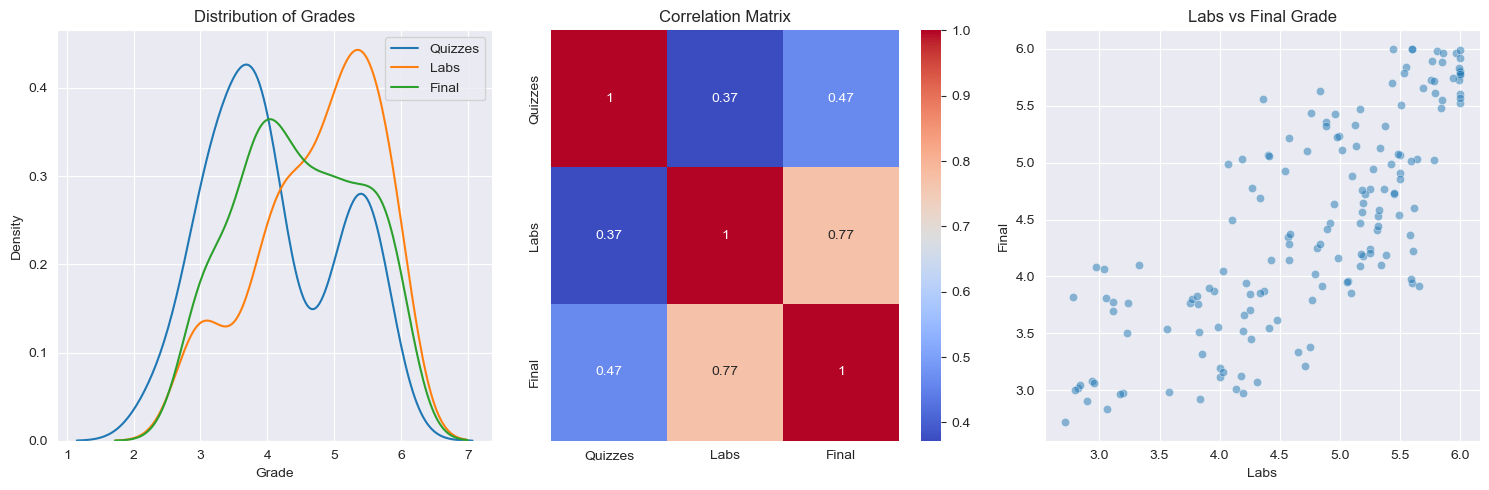

In [4]:
# Data Exploration and Visualization
plt.figure(figsize=(15, 5))

# Distribution of grades
plt.subplot(131)
sns.kdeplot(data=df_aug, x='Quizzes', label='Quizzes')
sns.kdeplot(data=df_aug, x='Labs', label='Labs')
sns.kdeplot(data=df_aug, x='Final', label='Final')
plt.title('Distribution of Grades')
plt.xlabel('Grade')
plt.ylabel('Density')
plt.legend()


# Correlation heatmap
plt.subplot(132)
sns.heatmap(df_aug.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

# Pairplot
plt.subplot(133)
sns.scatterplot(data=df_aug, x='Labs', y='Final', alpha=0.5)
plt.title('Labs vs Final Grade')
plt.tight_layout()
plt.show()

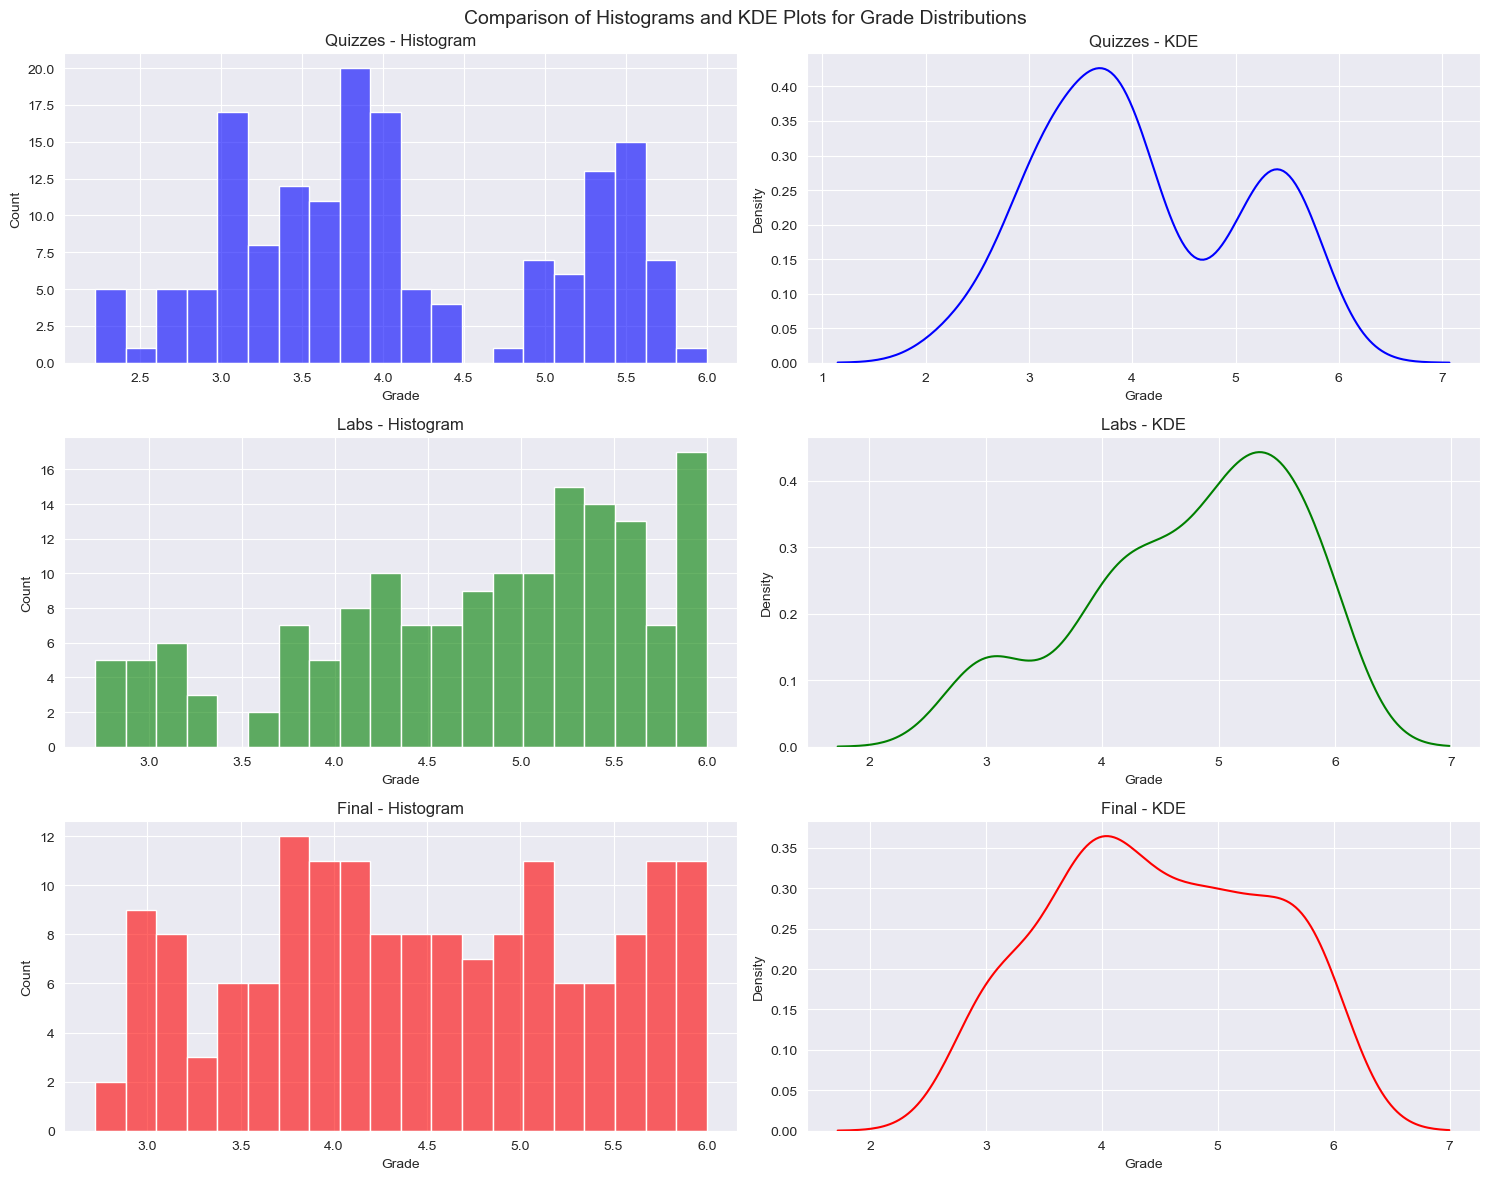


Summary Statistics:
       Quizzes     Labs    Final
count  160.000  160.000  160.000
mean     4.091    4.762    4.479
std      0.984    0.905    0.919
min      2.220    2.710    2.719
25%      3.336    4.190    3.809
50%      3.861    4.952    4.432
75%      5.090    5.492    5.229
max      6.000    6.000    6.000


In [5]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
plt.suptitle('Comparison of Histograms and KDE Plots for Grade Distributions', fontsize=14)


colors = {'Quizzes': 'blue', 'Labs': 'green', 'Final': 'red'}

for idx, column in enumerate(df_aug.columns):
    # Histogram
    sns.histplot(data=df_aug[column], bins=20, ax=axes[idx, 0], color=colors[column], alpha=0.6)
    axes[idx, 0].set_title(f'{column} - Histogram')
    axes[idx, 0].set_xlabel('Grade')
    axes[idx, 0].set_ylabel('Count')
    
    # KDE
    sns.kdeplot(data=df_aug[column], ax=axes[idx, 1], color=colors[column])
    axes[idx, 1].set_title(f'{column} - KDE')
    axes[idx, 1].set_xlabel('Grade')
    axes[idx, 1].set_ylabel('Density')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(df_aug.describe().round(3))

Now we will implement the closed form (analytical version) of linear regression.


**Implementation of the normal equation for univariate linear regression**

Optimal parameters:
θ₀ (intercept) = 0.754
θ₁ (slope) = 0.782
MSE = 0.342


/Users/jonas/miniconda3/envs/MLDM/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jonas/miniconda3/envs/MLDM/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


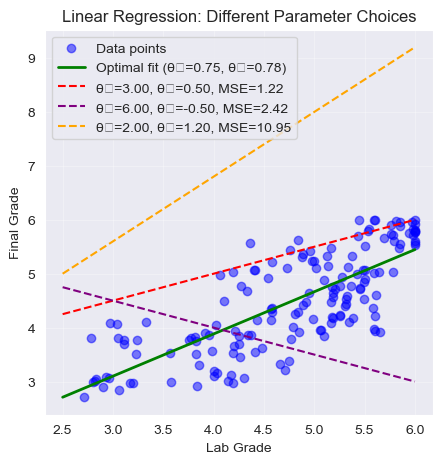

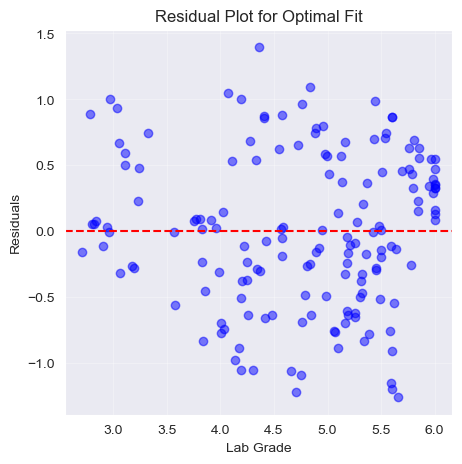

R² Score: 0.593


In [6]:
# Convert to numpy arrays
X = np.array(df_aug['Labs'])
y = np.array(df_aug['Final'])

# Closed form solution using the normal equation
X_with_ones = np.column_stack([np.ones_like(X), X])
optimal_params = np.linalg.inv(X_with_ones.T @ X_with_ones) @ X_with_ones.T @ y
optimal_theta0, optimal_theta1 = optimal_params

# Function to compute MSE (univariate case)
def compute_mse(theta0, theta1, X, y):
    y_pred = theta0 + theta1 * X
    return np.mean((y - y_pred) ** 2)

# plotting
plt.figure(figsize=(5, 5))

# Scatter plot of original data
plt.scatter(X, y, color='blue', alpha=0.5, label='Data points')

# Plot range for regression lines
x_range = np.array([2.5, 6.0])

# optimal line
y_optimal = optimal_theta0 + optimal_theta1 * x_range
plt.plot(x_range, y_optimal, 'g-', linewidth=2, 
         label=f'Optimal fit (θ₀={optimal_theta0:.2f}, θ₁={optimal_theta1:.2f})')

# bad fits
bad_fits = [
    (3, 0.5, 'red'),    # Too flat
    (6, -0.5, 'purple'),  # Negative slope
    (2, 1.2, 'orange'),   # Too steep
]

for theta0, theta1, color in bad_fits:
    y_bad = theta0 + theta1 * x_range
    mse = compute_mse(theta0, theta1, X, y)
    plt.plot(x_range, y_bad, color=color, linestyle='--',
             label=f'θ₀={theta0:.2f}, θ₁={theta1:.2f}, MSE={mse:.2f}')

# Customize plot
plt.xlabel('Lab Grade')
plt.ylabel('Final Grade')
plt.title('Linear Regression: Different Parameter Choices')
plt.grid(True, alpha=0.3)
plt.legend()

# optimal parameters and MSE
optimal_mse = compute_mse(optimal_theta0, optimal_theta1, X, y)
print(f"Optimal parameters:")
print(f"θ₀ (intercept) = {optimal_theta0:.3f}")
print(f"θ₁ (slope) = {optimal_theta1:.3f}")
print(f"MSE = {optimal_mse:.3f}")

plt.show()

# residual plot for the optimal fit
plt.figure(figsize=(5, 5))

# Compute residuals for optimal fit
y_pred_optimal = optimal_theta0 + optimal_theta1 * X
residuals = y - y_pred_optimal

plt.scatter(X, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Lab Grade')
plt.ylabel('Residuals')
plt.title('Residual Plot for Optimal Fit')
plt.grid(True, alpha=0.3)

plt.show()



# Calculate R² (only for Labs vs Quizzes, so univariate)
r2 = r2_score(y, y_pred_optimal)


print(f"R² Score: {r2:.3f}")

**Residuals analysis**

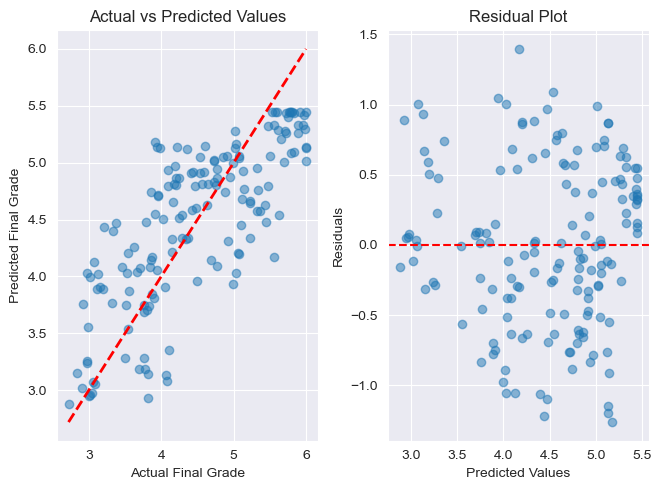

R² Score: 0.593


In [7]:
# Calculate residuals
residuals = y - y_pred_optimal


# Plotting
plt.figure(figsize=(10, 5))

# Actual vs Predicted
plt.subplot(131)
plt.scatter(y, y_pred_optimal, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Final Grade')
plt.ylabel('Predicted Final Grade')
plt.title('Actual vs Predicted Values')

# Residual Plot
plt.subplot(132)
plt.scatter(y_pred_optimal, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# QQ Plot

#plt.subplot(133)
#stats.probplot(residuals, dist="norm", plot=plt)
#plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()
print(f"R² Score: {r2_score(y, y_pred_optimal):.3f}")


In [8]:
# Statistics

print(f"R² Score: {r2_score(y, y_pred_optimal):.3f}")


print("\nResidual Statistics:")
print(f"Mean of Residuals: {np.mean(residuals):.3e}")  # Should be very close to 0
print(f"Standard Deviation of Residuals: {np.std(residuals):.3f}")
print(f"Range of Residuals: [{np.min(residuals):.3f}, {np.max(residuals):.3f}]")




# Q-Q plot
#plt.subplot(132)
#stats.probplot(residuals, dist="norm", plot=plt)
#plt.title('Q-Q Plot of Residuals')

# Residual histogram
#plt.subplot(133)
#plt.hist(residuals, bins=20, edgecolor='black')
#plt.title('Distribution of Residuals')
#plt.xlabel('Residual Value')
#plt.ylabel('Count')
#plt.tight_layout()
#plt.show()

R² Score: 0.593

Residual Statistics:
Mean of Residuals: 1.715e-14
Standard Deviation of Residuals: 0.584
Range of Residuals: [-1.262, 1.396]


**Multivariate regression**

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Initial data
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Augment data
np.random.seed(42)
augmented = []
for i in range(len(df)):
    row = df.iloc[i]
    for _ in range(10):
        noise = np.random.normal(0, 0.2, 3)
        new_row = row + noise
        new_row = new_row.clip(2, 6)
        augmented.append(new_row)

df_aug = pd.DataFrame(augmented, columns=df.columns)

# Compute optimal parameters using closed form solution
X = df_aug[['Quizzes', 'Labs']].values
y = df_aug['Final'].values
X_with_ones = np.column_stack([np.ones(len(X)), X])
optimal_params = np.linalg.inv(X_with_ones.T @ X_with_ones) @ X_with_ones.T @ y
theta_opt = optimal_params

# Function to compute predicted values for a grid
def compute_plane(theta0, theta1, theta2, xx, yy):
    return theta0 + theta1 * xx + theta2 * yy

/var/folders/br/xflg5m_916s1bn1pdq6h9p3w0000gn/T/ipykernel_10645/1921739608.py:42: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/br/xflg5m_916s1bn1pdq6h9p3w0000gn/T/ipykernel_10645/1921739608.py:42: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/br/xflg5m_916s1bn1pdq6h9p3w0000gn/T/ipykernel_10645/1921739608.py:42: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/jonas/miniconda3/envs/MLDM/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jonas/miniconda3/envs/MLDM/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jonas/miniconda3/envs/MLDM/lib/python3.12/sit

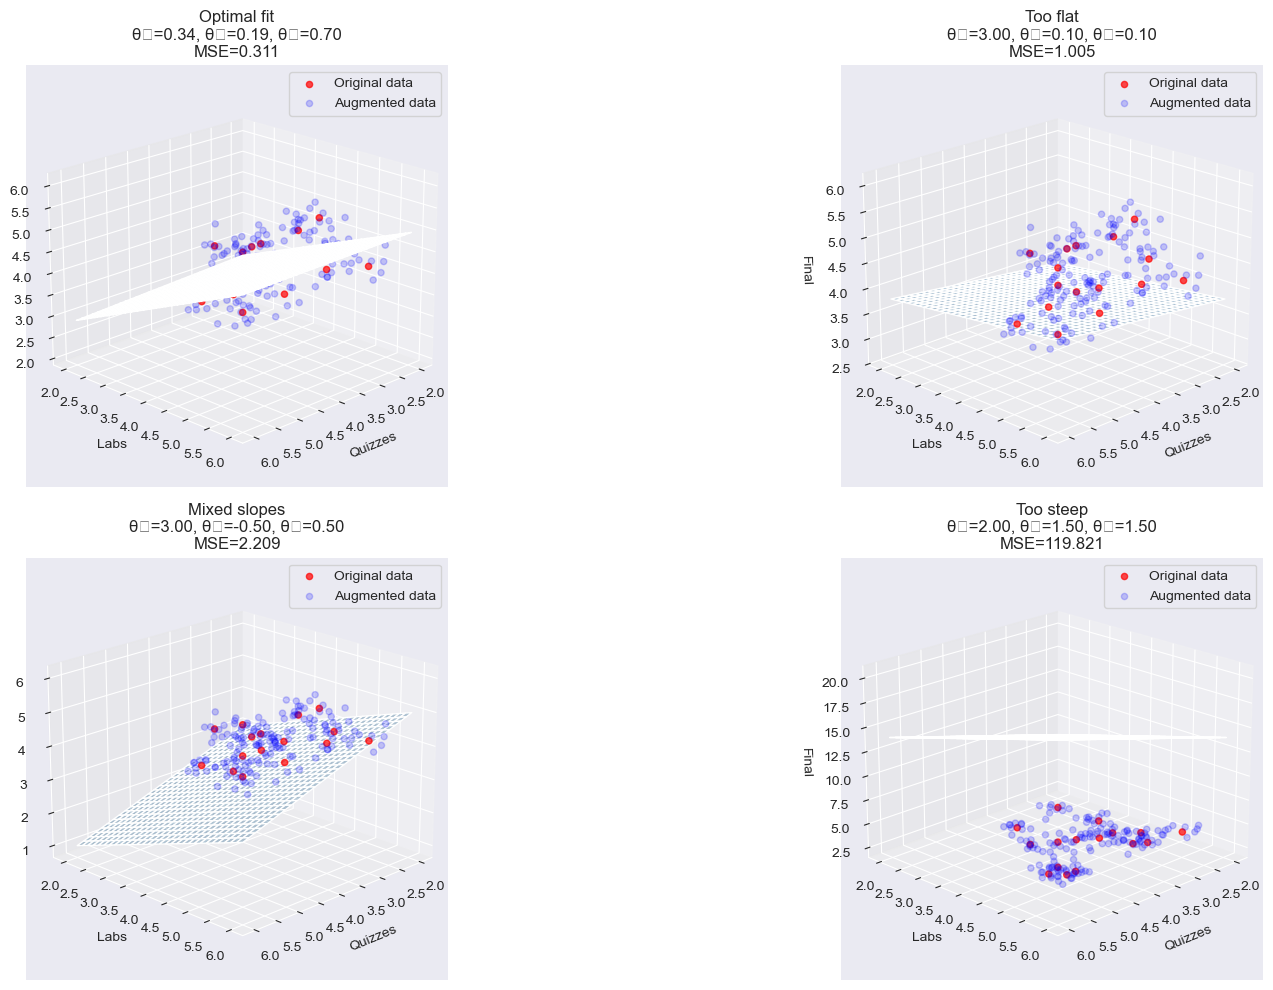


Optimal parameters:
θ₀ (intercept) = 0.335
θ₁ (Quizzes coefficient) = 0.193
θ₂ (Labs coefficient) = 0.704


In [10]:
# Create meshgrid for plotting
x_range = np.linspace(2, 6, 30)
y_range = np.linspace(2, 6, 30)
xx, yy = np.meshgrid(x_range, y_range)

# Create figure with subplots
fig = plt.figure(figsize=(20, 10))

# List of parameter sets to visualize
parameter_sets = [    (theta_opt, 'Optimal fit'),
    ([3, 0.1, 0.1], 'Too flat'),
    ([3, -0.5, 0.5], 'Mixed slopes'),
    ([2, 1.5, 1.5], 'Too steep')
]

# Plot each parameter set
for idx, (params, title) in enumerate(parameter_sets, 1):
    ax = fig.add_subplot(2, 2, idx, projection='3d')
    
    # Plot the data points
    ax.scatter(df['Quizzes'], df['Labs'], df['Final'], 
              color='red', alpha=0.7, label='Original data')
    ax.scatter(df_aug['Quizzes'], df_aug['Labs'], df_aug['Final'], 
              color='blue', alpha=0.2, label='Augmented data')
    
    # Plot the regression plane
    zz = compute_plane(params[0], params[1], params[2], xx, yy)
    surf = ax.plot_surface(xx, yy, zz, alpha=0.3)
    
    # Calculate MSE
    y_pred = params[0] + params[1] * X[:, 0] + params[2] * X[:, 1]
    mse = np.mean((y - y_pred) ** 2)
    
    ax.set_xlabel('Quizzes')
    ax.set_ylabel('Labs')
    ax.set_zlabel('Final')
    ax.set_title(f'{title}\nθ₀={params[0]:.2f}, θ₁={params[1]:.2f}, θ₂={params[2]:.2f}\nMSE={mse:.3f}')
    ax.legend()
    
    ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

# Print optimal parameters
print("\nOptimal parameters:")
print(f"θ₀ (intercept) = {theta_opt[0]:.3f}")
print(f"θ₁ (Quizzes coefficient) = {theta_opt[1]:.3f}")
print(f"θ₂ (Labs coefficient) = {theta_opt[2]:.3f}")

**Analysis of the Multivariate Linear Regression results**

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats


# Calculate predicted values and residuals
y_pred = X_with_ones @ theta_opt
residuals = y - y_pred
standardized_residuals = residuals / np.std(residuals)

# Create a figure for diagnostics
plt.figure(figsize=(20, 15))

# 1. Residuals vs Fitted Values Plot
plt.subplot(2, 2, 1)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values\n(Check for Linearity and Homoscedasticity)')

# 2. Q-Q Plot for Normality
plt.subplot(2, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot\n(Check for Normality of Residuals)')

# 3. Scale-Location Plot
plt.subplot(2, 2, 3)
plt.scatter(y_pred, np.abs(standardized_residuals))
plt.xlabel('Fitted Values')
plt.ylabel('|Standardized Residuals|^1/2')
plt.title('Scale-Location Plot\n(Check for Homoscedasticity)')

# 4. Correlation Matrix Heatmap
plt.subplot(2, 2, 4)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix\n(Check for Multicollinearity)')

plt.tight_layout()

# Statistical Tests
print("\nDiagnostic Tests:")
print("-----------------")

# 1. Normality Test (Shapiro-Wilk)
_, p_value_normality = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test for Normality:")
print(f"p-value: {p_value_normality:.4f}")
print(f"Interpretation: {'Residuals appear normal' if p_value_normality > 0.05 else 'Residuals may not be normal'}")

# 2. Manual Heteroscedasticity Test (Spearman correlation between absolute residuals and predicted values)
correlation, p_value_hetero = stats.spearmanr(np.abs(residuals), y_pred)
print(f"\nHeteroscedasticity Test (Spearman correlation):")
print(f"Correlation: {correlation:.4f}")
print(f"p-value: {p_value_hetero:.4f}")
print(f"Interpretation: {'Homoscedasticity assumption holds' if p_value_hetero > 0.05 else 'Heteroscedasticity may be present'}")


# 4. Model Fit Statistics
n = len(y)
p = X.shape[1]
r_squared = 1 - (np.sum(residuals**2) / np.sum((y - np.mean(y))**2))
adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

print("\nModel Fit Statistics:")
print(f"R-squared: {r_squared:.4f}")
print(f"Adjusted R-squared: {adj_r_squared:.4f}")

# 5. Additional residual statistics
print("\nResidual Statistics:")
print(f"Mean of residuals: {np.mean(residuals):.4f}")
print(f"Standard deviation of residuals: {np.std(residuals):.4f}")


plt.show()

ModuleNotFoundError: No module named 'statsmodels'

**Checking for correlated features (multicollinearity)**

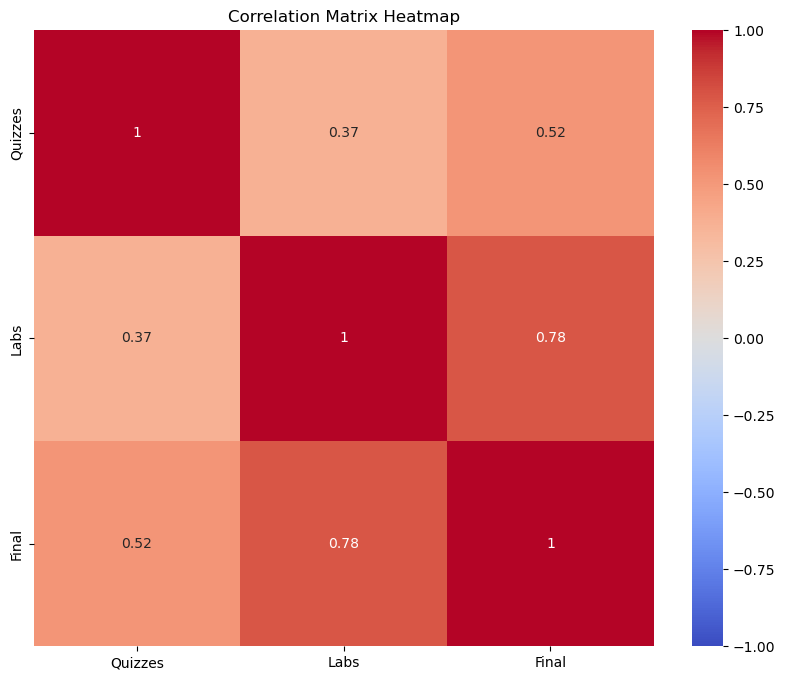


Condition Number: 1.26
Interpretation:
- < 10: Weak multicollinearity
- 10-30: Moderate multicollinearity
- > 30: Strong multicollinearity

Pearson Correlation Test:
Correlation coefficient: 0.3684
P-value: 0.1603


In [21]:
# Correlation Matrix and Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()


# Condition Number
X_scaled = (X - X.mean()) / X.std()
eigenvals = np.linalg.eigvals(X_scaled.T @ X_scaled)
condition_number = np.sqrt(max(abs(eigenvals)) / min(abs(eigenvals)))
print(f"\nCondition Number: {condition_number:.2f}")
print("Interpretation:")
print("- < 10: Weak multicollinearity")
print("- 10-30: Moderate multicollinearity")
print("- > 30: Strong multicollinearity")

# Pearson Correlation Test
correlation_coef, p_value = stats.pearsonr(df['Quizzes'], df['Labs'])
print(f"\nPearson Correlation Test:")
print(f"Correlation coefficient: {correlation_coef:.4f}")
print(f"P-value: {p_value:.4f}")

**Standardized residuals**

Summary Statistics:

Regular Residuals:
Mean: -0.0000
Standard Deviation: 0.6060
Min: -1.1347
Max: 1.4564

Standardized Residuals:
Mean: -0.0000
Standard Deviation: 1.0000
Min: -1.8724
Max: 2.4032

Number of points outside ±2 standard deviations: 3


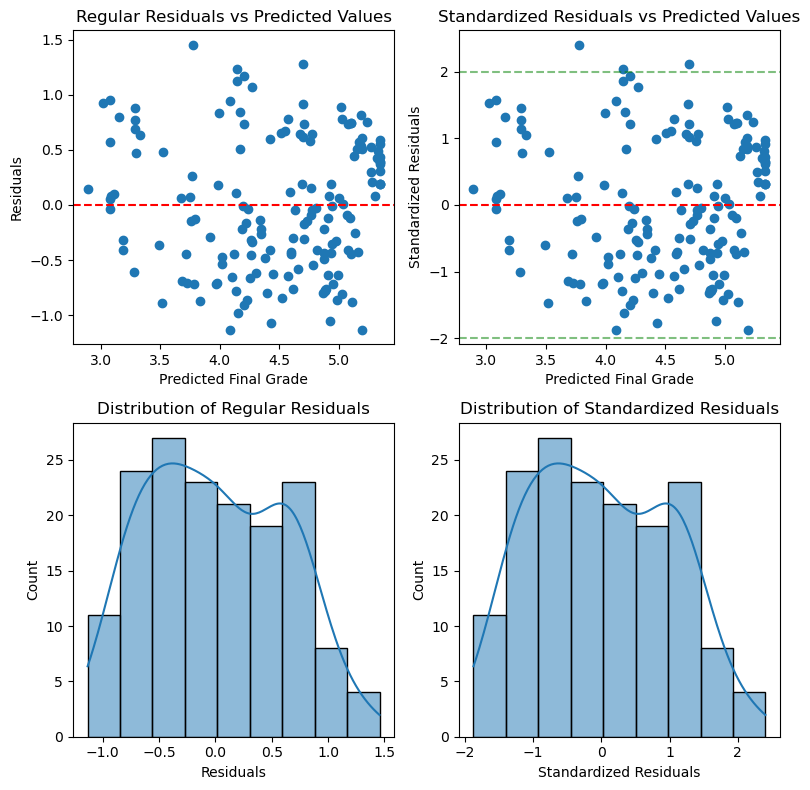

In [24]:
# Data (univariate again)
data = {
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}
df = pd.DataFrame(data)

# Augment data
np.random.seed(42)
augmented = []
for i in range(len(df)):
    row = df.iloc[i]
    for _ in range(10):
        noise = np.random.normal(0, 0.2, 2)
        new_row = row + noise
        new_row = new_row.clip(2, 6)
        augmented.append(new_row)

df_aug = pd.DataFrame(augmented, columns=df.columns)


# Simple linear regression
X = df_aug['Labs'].values.reshape(-1, 1)
y = df_aug['Final'].values
X_with_ones = np.column_stack([np.ones(len(X)), X])
theta = np.linalg.inv(X_with_ones.T @ X_with_ones) @ X_with_ones.T @ y

# Calculate predicted values
y_pred = X_with_ones @ theta

# Calculate residuals
residuals = y - y_pred

# Calculate standardized residuals
# Standardized residuals = residuals / standard deviation of residuals
standardized_residuals = residuals / np.std(residuals)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# 1. Regular Residuals vs Predicted
axes[0, 0].scatter(y_pred, residuals)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Predicted Final Grade')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Regular Residuals vs Predicted Values')

# 2. Standardized Residuals vs Predicted
axes[0, 1].scatter(y_pred, standardized_residuals)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].axhline(y=2, color='g', linestyle='--', alpha=0.5)
axes[0, 1].axhline(y=-2, color='g', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Predicted Final Grade')
axes[0, 1].set_ylabel('Standardized Residuals')
axes[0, 1].set_title('Standardized Residuals vs Predicted Values')

# 3. Regular Residuals Distribution
sns.histplot(residuals, kde=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_title('Distribution of Regular Residuals')

# 4. Standardized Residuals Distribution
sns.histplot(standardized_residuals, kde=True, ax=axes[1, 1])
axes[1, 1].set_xlabel('Standardized Residuals')
axes[1, 1].set_title('Distribution of Standardized Residuals')

plt.tight_layout()

# Print summary statistics
print("Summary Statistics:")
print("\nRegular Residuals:")
print(f"Mean: {np.mean(residuals):.4f}")
print(f"Standard Deviation: {np.std(residuals):.4f}")
print(f"Min: {np.min(residuals):.4f}")
print(f"Max: {np.max(residuals):.4f}")

print("\nStandardized Residuals:")
print(f"Mean: {np.mean(standardized_residuals):.4f}")
print(f"Standard Deviation: {np.std(standardized_residuals):.4f}")
print(f"Min: {np.min(standardized_residuals):.4f}")
print(f"Max: {np.max(standardized_residuals):.4f}")

# Count points outside ±2 standard deviations
outliers = np.sum(np.abs(standardized_residuals) > 2)
print(f"\nNumber of points outside ±2 standard deviations: {outliers}")

plt.show()

**Assumptions of linear regression**

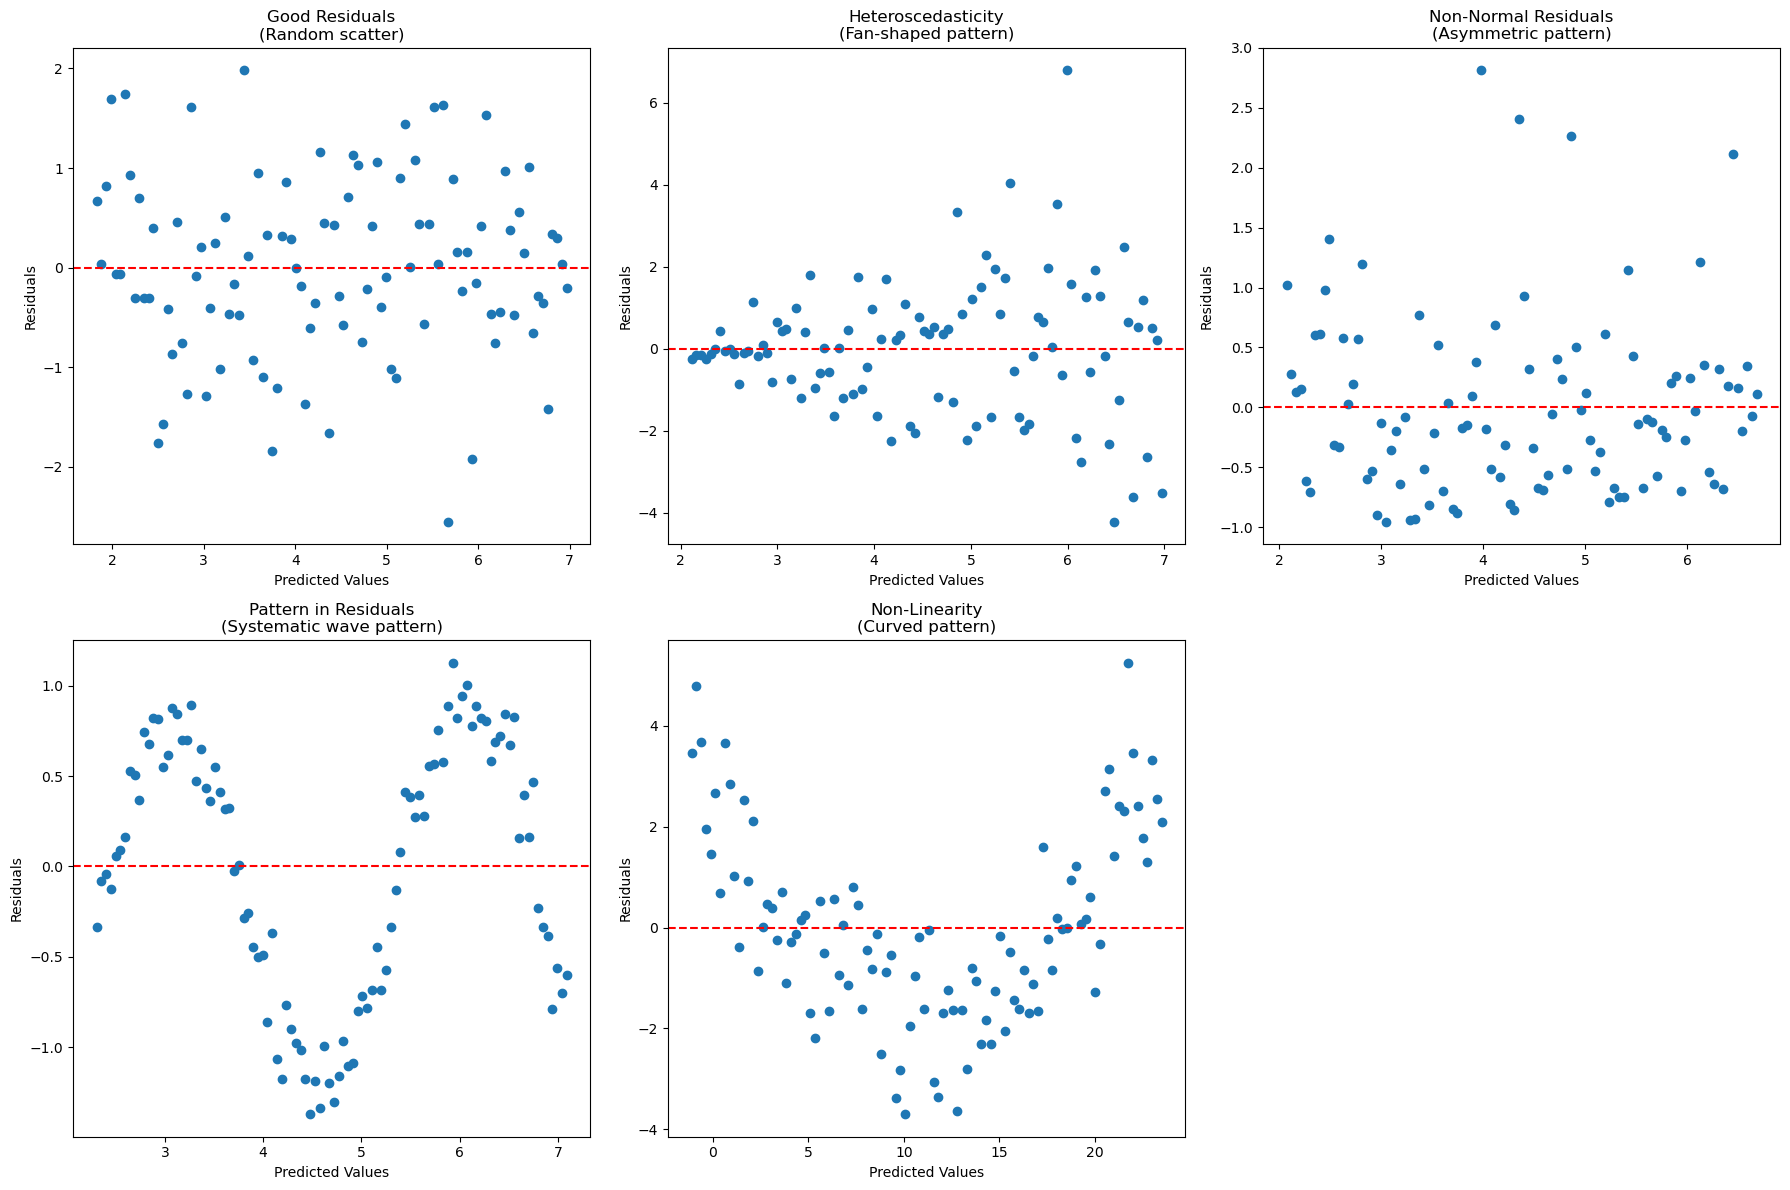

0. Good Residuals:
   - Mean close to zero: -0.000
   - Constant variance: 0.941 vs 0.675
   - Normality (skewness): -0.167
   - Correlation with predicted: -0.000

Violating the assumptions of linear regression:
1. Heteroscedasticity - varying std: 0.4321294590954378 vs 2.012141155500898
2. Non-normality - skewness: 1.4076983352368515
3. Patterns - autocorrelation: 0.948335755953996
4. Non-linearity - correlation: -2.4695157880862577e-15


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

np.random.seed(42)

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

#  Good Residuals 
x0 = np.linspace(0, 10, 100)
noise0 = np.random.normal(0, 1, 100)  # Constant variance, normal distribution
y0 = 2 + 0.5 * x0 + noise0
model0 = np.polyfit(x0, y0, 1)
y0_pred = np.polyval(model0, x0)
residuals0 = y0 - y0_pred

axes[0,0].scatter(y0_pred, residuals0)
axes[0,0].axhline(y=0, color='r', linestyle='--')
axes[0,0].set_xlabel('Predicted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Good Residuals\n(Random scatter)')

#  Heteroscedasticity
x1 = np.linspace(0, 10, 100)
noise1 = np.random.normal(0, 0.1 + 0.3 * x1, 100)
y1 = 2 + 0.5 * x1 + noise1
model1 = np.polyfit(x1, y1, 1)
y1_pred = np.polyval(model1, x1)
residuals1 = y1 - y1_pred

axes[0,1].scatter(y1_pred, residuals1)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predicted Values')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Heteroscedasticity\n(Fan-shaped pattern)')

#  Non-normality
x2 = np.linspace(0, 10, 100)
noise2 = np.random.exponential(1, 100) - 1
y2 = 2 + 0.5 * x2 + noise2
model2 = np.polyfit(x2, y2, 1)
y2_pred = np.polyval(model2, x2)
residuals2 = y2 - y2_pred



axes[0,2].scatter(y2_pred, residuals2)
axes[0,2].axhline(y=0, color='r', linestyle='--')
axes[0,2].set_xlabel('Predicted Values')
axes[0,2].set_ylabel('Residuals')
axes[0,2].set_title('Non-Normal Residuals\n(Asymmetric pattern)')

#  Patterns in residuals
x3 = np.linspace(0, 10, 100)
noise3 = np.sin(x3) + np.random.normal(0, 0.2, 100)
y3 = 2 + 0.5 * x3 + noise3
model3 = np.polyfit(x3, y3, 1)
y3_pred = np.polyval(model3, x3)
residuals3 = y3 - y3_pred

axes[1,0].scatter(y3_pred, residuals3)
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_xlabel('Predicted Values')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Pattern in Residuals\n(Systematic wave pattern)')

#  Non-linearity
x4 = np.linspace(0, 10, 100)
y4 = 2 + 0.5 * x4 + 0.2 * x4**2 + np.random.normal(0, 1, 100)
model4 = np.polyfit(x4, y4, 1)
y4_pred = np.polyval(model4, x4)
residuals4 = y4 - y4_pred

axes[1,1].scatter(y4_pred, residuals4)
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_xlabel('Predicted Values')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Non-Linearity\n(Curved pattern)')

# Remove the unused subplot
axes[1,2].remove()

plt.tight_layout()
plt.show()

# Print characteristics of each case
print("0. Good Residuals:")
print(f"   - Mean close to zero: {np.mean(residuals0):.3f}")
print(f"   - Constant variance: {np.std(residuals0[:20]):.3f} vs {np.std(residuals0[-20:]):.3f}")
print(f"   - Normality (skewness): {stats.skew(residuals0):.3f}")
print(f"   - Correlation with predicted: {np.corrcoef(y0_pred, residuals0)[0,1]:.3f}")

print("\nViolating the assumptions of linear regression:")
print("1. Heteroscedasticity - varying std:", np.std(residuals1[:20]), "vs", np.std(residuals1[-20:]))
print("2. Non-normality - skewness:", stats.skew(residuals2))
print("3. Patterns - autocorrelation:", np.corrcoef(residuals3[:-1], residuals3[1:])[0,1])
print("4. Non-linearity - correlation:", np.corrcoef(y4_pred, residuals4)[0,1])

In [26]:
#  Non-linearity
x4 = np.linspace(0, 10, 100)
y4 = 2 + 0.5 * x4 + 0.2 * x4**2 + np.random.normal(0, 1, 100)
model4 = np.polyfit(x4, y4, 2)
y4_pred = np.polyval(model4, x4)
residuals4 = y4 - y4_pred



y4_ok = 2 + 0.5 * x4 ++ np.random.normal(0, 1, 100)
model4_ok = np.polyfit(x4, y4_ok, 1)
y4_pred_ok = np.polyval(model4_ok, x4)
residuals4_ok = y4_ok - y4_pred_ok


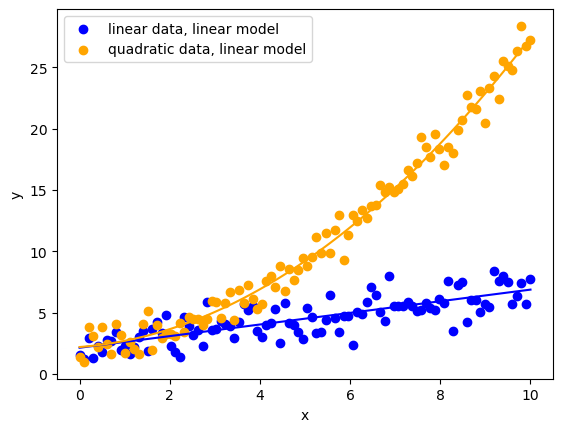

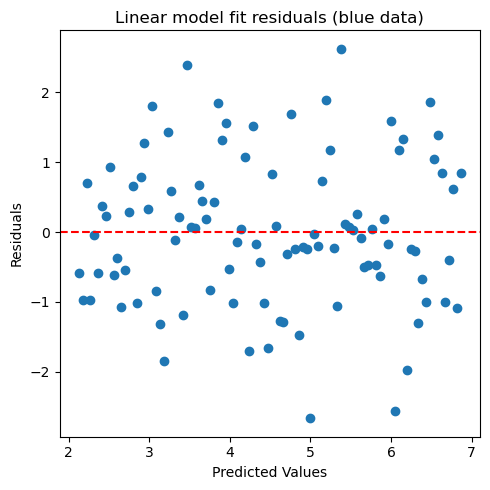

In [27]:
#comparing for linearity (quadratic relation between x and y fitted with  linear model)
plt.scatter(x4,y4_ok, color='blue',label='linear data, linear model' )
plt.plot(x4,y4_pred_ok, color='blue')
plt.scatter(x4,y4,color='orange',label='quadratic data, linear model')
plt.plot(x4,y4_pred, color='orange')
plt.xlabel('x')
plt.ylabel('y')

plt.legend()

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(y4_pred_ok, residuals4_ok)
axes.axhline(y=0, color='r', linestyle='--')
axes.set_xlabel('Predicted Values')
axes.set_ylabel('Residuals')
axes.set_title('Linear model fit residuals (blue data)')

plt.tight_layout()
plt.show()


Linear Regression Assumptions Tests:
----------------------------------------
1. Linearity:
   - Correlation coefficient: 0.7336
   - R-squared: 0.5382

2. Homoscedasticity:
   - Spearman correlation of |residuals| vs predicted: -0.1030
   - P-value: 0.1950
   - Interpretation: Homoscedasticity assumption appears met

3. Normality:
   - Normality test p-value: 0.0000
   - Skewness: 0.1610
   - Kurtosis: -0.9616
   - Interpretation: Non-normal residuals

4. Additional Information:
   - Mean of residuals: -0.0000
   - Std of residuals: 0.6060
   - Range of residuals: [-1.1347, 1.4564]


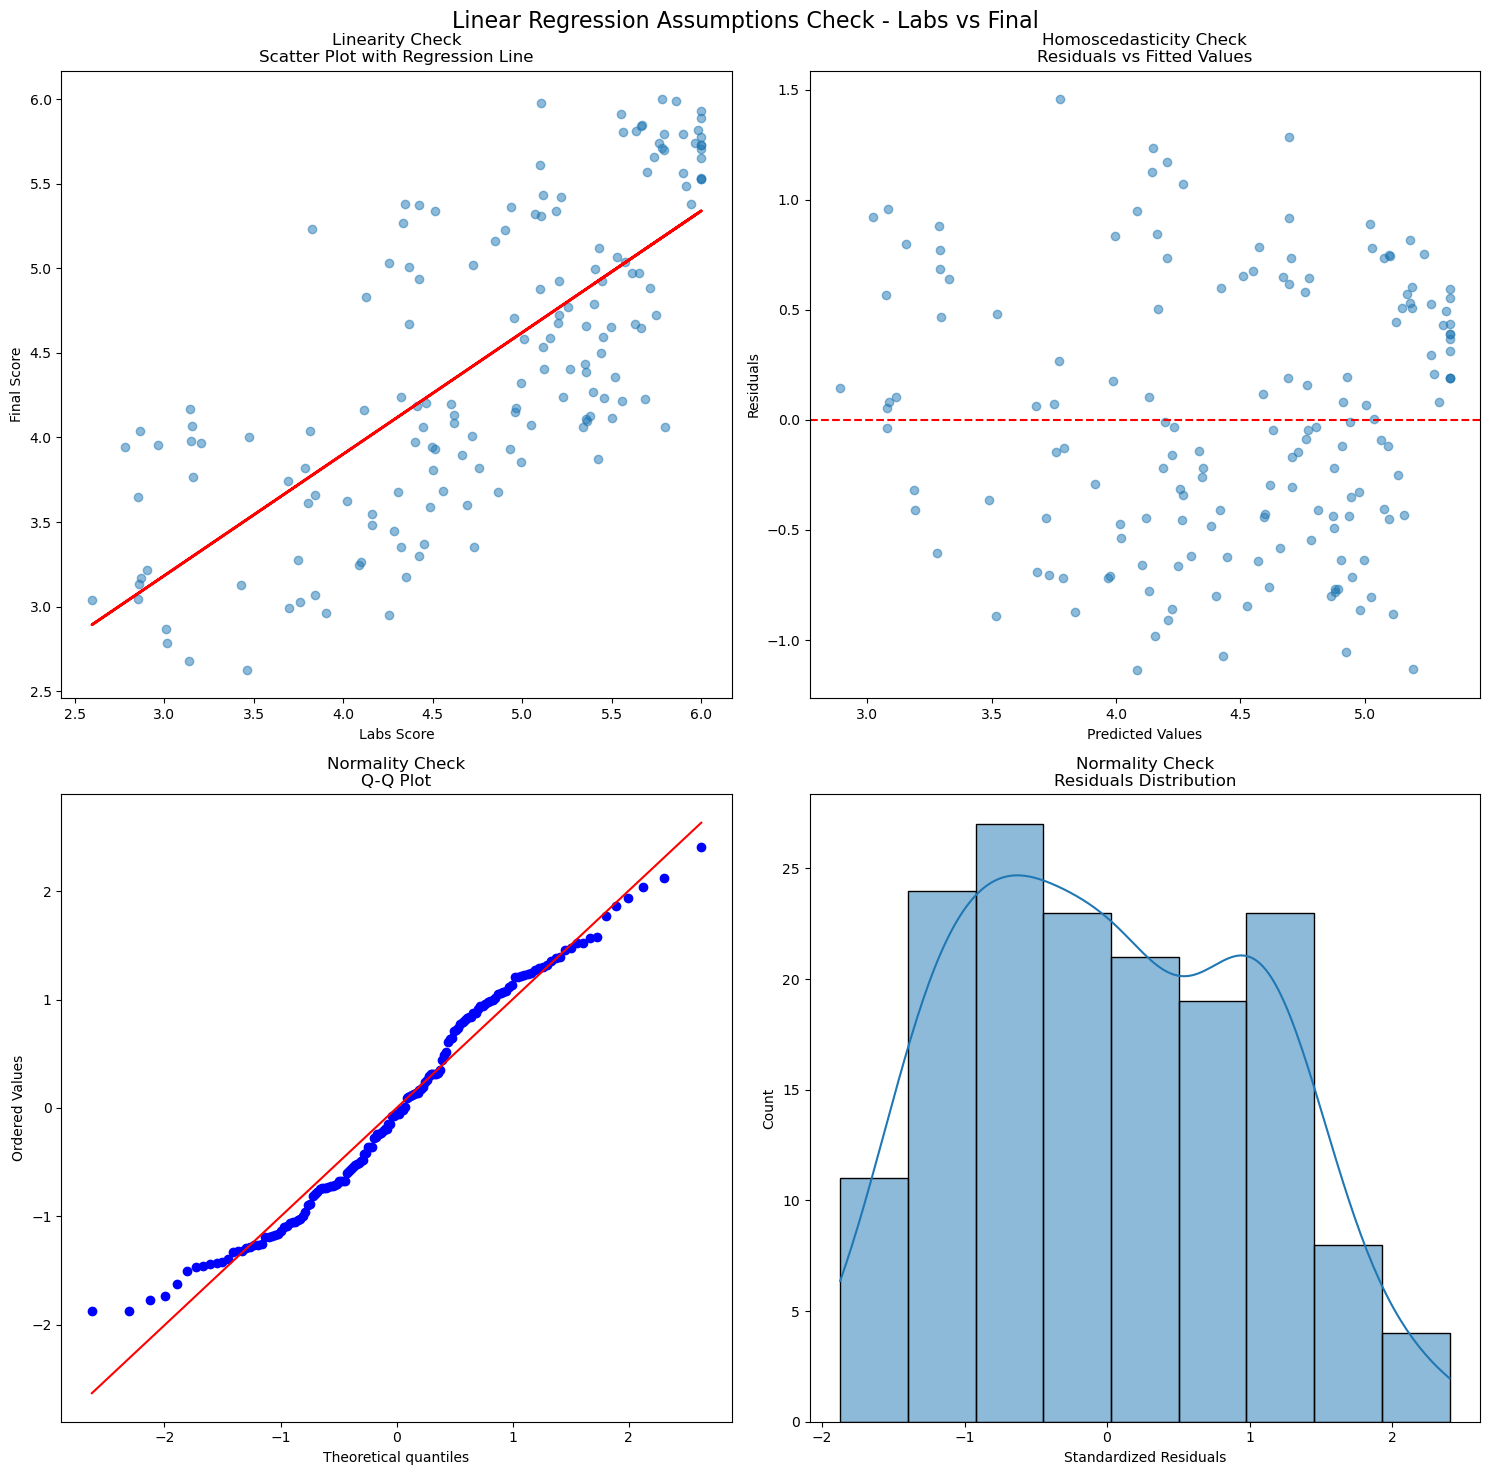

In [29]:
# back to our data


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Original data and augmentation
data = {
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}
df = pd.DataFrame(data)

# Augment data
np.random.seed(42)
augmented = []
for i in range(len(df)):
    row = df.iloc[i]
    for _ in range(10):
        noise = np.random.normal(0, 0.2, 2)
        new_row = row + noise
        new_row = new_row.clip(2, 6)
        augmented.append(new_row)

df_aug = pd.DataFrame(augmented, columns=df.columns)

# Fit linear regression
X = df_aug['Labs'].values.reshape(-1, 1)
y = df_aug['Final'].values
X_with_ones = np.column_stack([np.ones(len(X)), X])
theta = np.linalg.inv(X_with_ones.T @ X_with_ones) @ X_with_ones.T @ y

# Calculate predicted values and residuals
y_pred = X_with_ones @ theta
residuals = y - y_pred
standardized_residuals = residuals / np.std(residuals)

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Linear Regression Assumptions Check - Labs vs Final', fontsize=16)

# 1. Linearity Check - Scatter plot with regression line
axes[0,0].scatter(X, y, alpha=0.5)
axes[0,0].plot(X, y_pred, color='red', linewidth=2)
axes[0,0].set_xlabel('Labs Score')
axes[0,0].set_ylabel('Final Score')
axes[0,0].set_title('Linearity Check\nScatter Plot with Regression Line')

# 2. Homoscedasticity - Residuals vs Fitted
axes[0,1].scatter(y_pred, residuals, alpha=0.5)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predicted Values')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Homoscedasticity Check\nResiduals vs Fitted Values')

# 3. Normality - QQ Plot
stats.probplot(standardized_residuals, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Normality Check\nQ-Q Plot')

# 4. Residuals Distribution
sns.histplot(standardized_residuals, kde=True, ax=axes[1,1])
axes[1,1].set_xlabel('Standardized Residuals')
axes[1,1].set_title('Normality Check\nResiduals Distribution')

plt.tight_layout()

# Print statistical tests and metrics
print("Linear Regression Assumptions Tests:")
print("-" * 40)

#  Linearity - Correlation test
correlation = np.corrcoef(X.flatten(), y)[0,1]
print(f"1. Linearity:")
print(f"   - Correlation coefficient: {correlation:.4f}")
print(f"   - R-squared: {1 - (np.sum(residuals**2) / np.sum((y - np.mean(y))**2)):.4f}")

#  Homoscedasticity - Correlation between absolute residuals and predicted values
het_corr, het_p = stats.spearmanr(np.abs(residuals), y_pred)
print(f"\n2. Homoscedasticity:")
print(f"   - Spearman correlation of |residuals| vs predicted: {het_corr:.4f}")
print(f"   - P-value: {het_p:.4f}")
print(f"   - Interpretation: {'Possible heteroscedasticity' if het_p < 0.05 else 'Homoscedasticity assumption appears met'}")

#  Normality tests
_, normality_p = stats.normaltest(residuals)
print(f"\n3. Normality:")
print(f"   - Normality test p-value: {normality_p:.4f}")
print(f"   - Skewness: {stats.skew(residuals):.4f}")
print(f"   - Kurtosis: {stats.kurtosis(residuals):.4f}")
print(f"   - Interpretation: {'Non-normal residuals' if normality_p < 0.05 else 'Normal residuals'}")

# § Additional metrics
print(f"\n4. Additional Information:")
print(f"   - Mean of residuals: {np.mean(residuals):.4f}")
print(f"   - Std of residuals: {np.std(residuals):.4f}")
print(f"   - Range of residuals: [{np.min(residuals):.4f}, {np.max(residuals):.4f}]")

plt.show()

For homoscedastisicy (equality of variance in the residuals) one of the best ways to check is by visual inspection of the residuals plot.

In [30]:
x1 = np.linspace(0, 10, 100)
noise1 = np.random.normal(0, 0.1 + 0.3 * x1, 100)
y1 = 2 + 0.5 * x1 + noise1
model1 = np.polyfit(x1, y1, 1)
y1_pred = np.polyval(model1, x1)
residuals1 = y1 - y1_pred

y1_ok = 2 + 0.5 * x1 ++ np.random.normal(0, 1, 100)
model1_ok = np.polyfit(x1, y1_ok, 1)
y1_pred_ok = np.polyval(model1_ok, x1)
residuals1_ok = y1_ok - y1_pred_ok


axes[0,1].scatter(y1_pred, residuals1)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predicted Values')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Heteroscedasticity\n(Fan-shaped pattern)')

Text(0.5, 1.0, 'Heteroscedasticity\n(Fan-shaped pattern)')

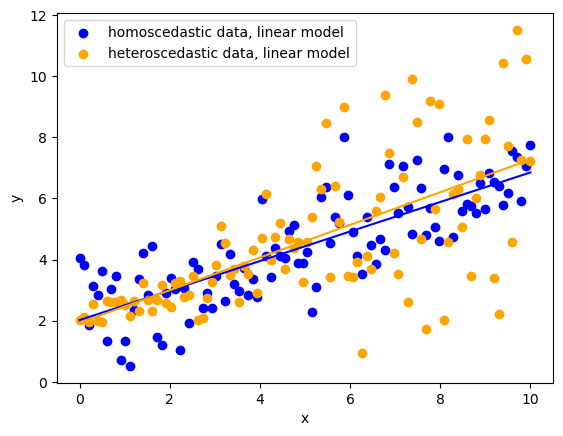

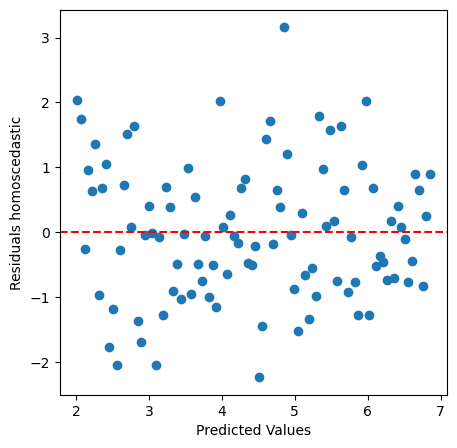

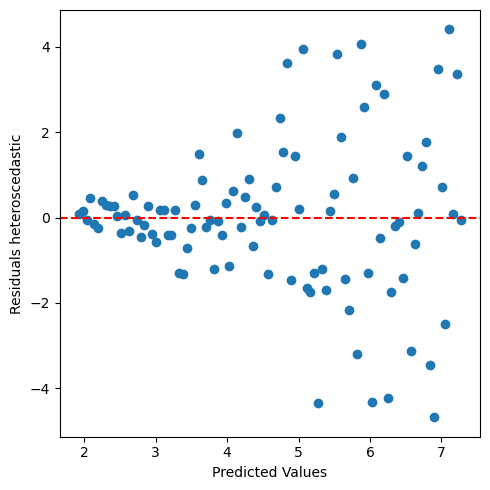

In [31]:
#comparing for homopscedasticity (equality of variance of the residuals over the whole range)
plt.scatter(x1,y1_ok, color='blue',label='homoscedastic data, linear model' )
plt.plot(x1,y1_pred_ok, color='blue')
plt.scatter(x1,y1,color='orange',label='heteroscedastic data, linear model')
plt.plot(x1,y1_pred, color='orange')
plt.xlabel('x')
plt.ylabel('y')

plt.legend()

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plt.scatter(y1_pred_ok, residuals1_ok, label='homoscedastic residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals homoscedastic')

fig, axes = plt.subplots(1, 1, figsize=(5, 5))

plt.scatter(y1_pred, residuals1,label='heteroscedastic residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
axes.set_ylabel('Residuals heteroscedastic')


plt.tight_layout()
plt.show()

Checking for independence

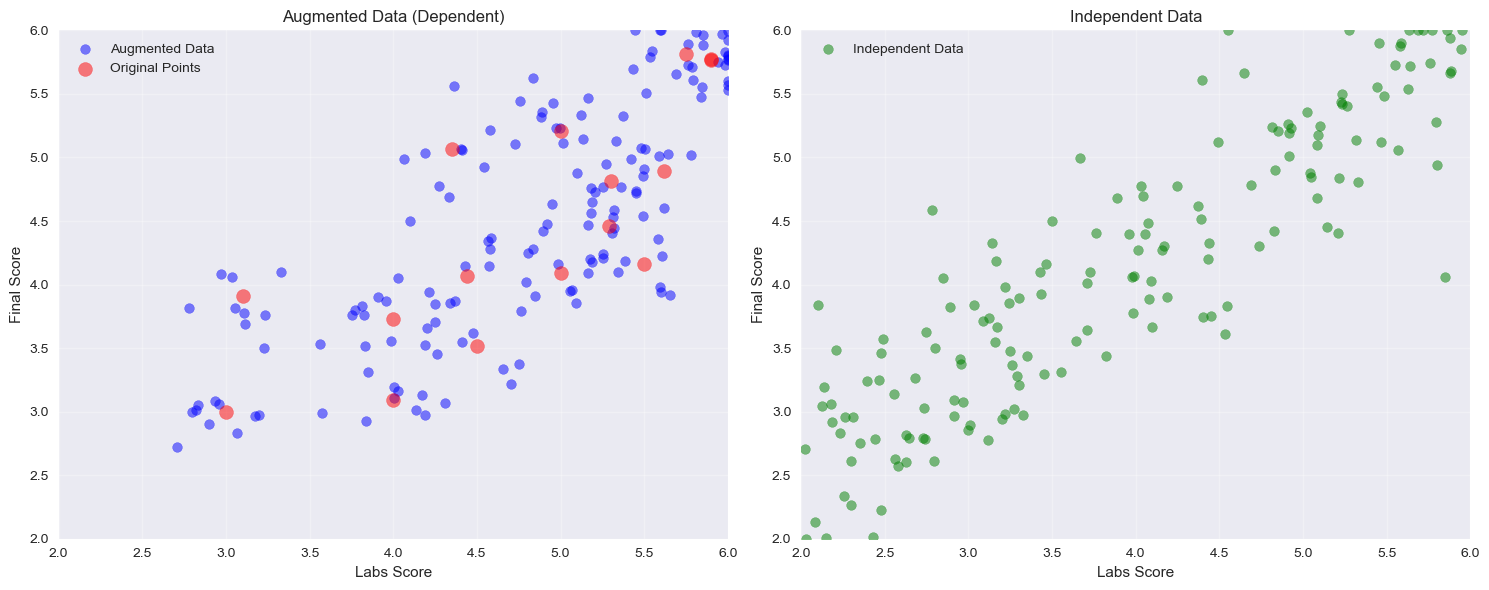


Augmented Data Statistics:
             Labs       Final
count  160.000000  160.000000
mean     4.762389    4.479292
std      0.904538    0.918909
min      2.710383    2.718507
25%      4.189950    3.808585
50%      4.951766    4.432312
75%      5.491895    5.229416
max      6.000000    6.000000

Independent Data Statistics:
             Labs       Final
count  160.000000  160.000000
mean     3.908564    4.126841
std      1.187372    1.088667
min      2.022088    2.000000
25%      2.905913    3.248587
50%      3.856570    4.056825
75%      5.027438    5.069239
max      5.947548    6.000000

Correlation Coefficients:
Augmented Data: 0.7700109814696267
Independent Data: 0.8952450360253382


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Original data
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create augmented data
np.random.seed(42)
augmented = []
for i in range(len(df)):
    row = df.iloc[i]
    for _ in range(10):  # Create 10 variations of each record
        noise = np.random.normal(0, 0.2, 3)  # Add Gaussian noise
        new_row = row + noise
        # Ensure values are within boundaries
        new_row = new_row.clip(2, 6)
        augmented.append(new_row)

# Create augmented DataFrame
df_aug = pd.DataFrame(augmented, columns=df.columns)

# Generate independent data
np.random.seed(42)
n_points = len(df_aug)
labs_independent = np.random.uniform(2, 6, n_points)
noise = np.random.normal(0, 0.5, n_points)
final_independent = np.clip(labs_independent * 0.8 + noise + 1, 2, 6)

# Create figure with two subplots
plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot augmented data
ax1.scatter(df_aug['Labs'], df_aug['Final'], alpha=0.5, c='blue', label='Augmented Data')
ax1.set_title('Augmented Data (Dependent)')
ax1.set_xlabel('Labs Score')
ax1.set_ylabel('Final Score')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(2, 6)
ax1.set_ylim(2, 6)

# Plot original points to highlight clusters
ax1.scatter(df['Labs'], df['Final'], c='red', s=100, alpha=0.5, label='Original Points')
ax1.legend()

# Plot independent data
ax2.scatter(labs_independent, final_independent, alpha=0.5, c='green', label='Independent Data')
ax2.set_title('Independent Data')
ax2.set_xlabel('Labs Score')
ax2.set_ylabel('Final Score')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(2, 6)
ax2.set_ylim(2, 6)
ax2.legend()

plt.tight_layout()
plt.show()

# Print some statistics to compare the distributions
print("\nAugmented Data Statistics:")
print(df_aug[['Labs', 'Final']].describe())
print("\nIndependent Data Statistics:")
independent_df = pd.DataFrame({'Labs': labs_independent, 'Final': final_independent})
print(independent_df.describe())

# Calculate and print correlation coefficients
print("\nCorrelation Coefficients:")
print("Augmented Data:", np.corrcoef(df_aug['Labs'], df_aug['Final'])[0,1])
print("Independent Data:", np.corrcoef(labs_independent, final_independent)[0,1])

In [ ]:
plt.style.available

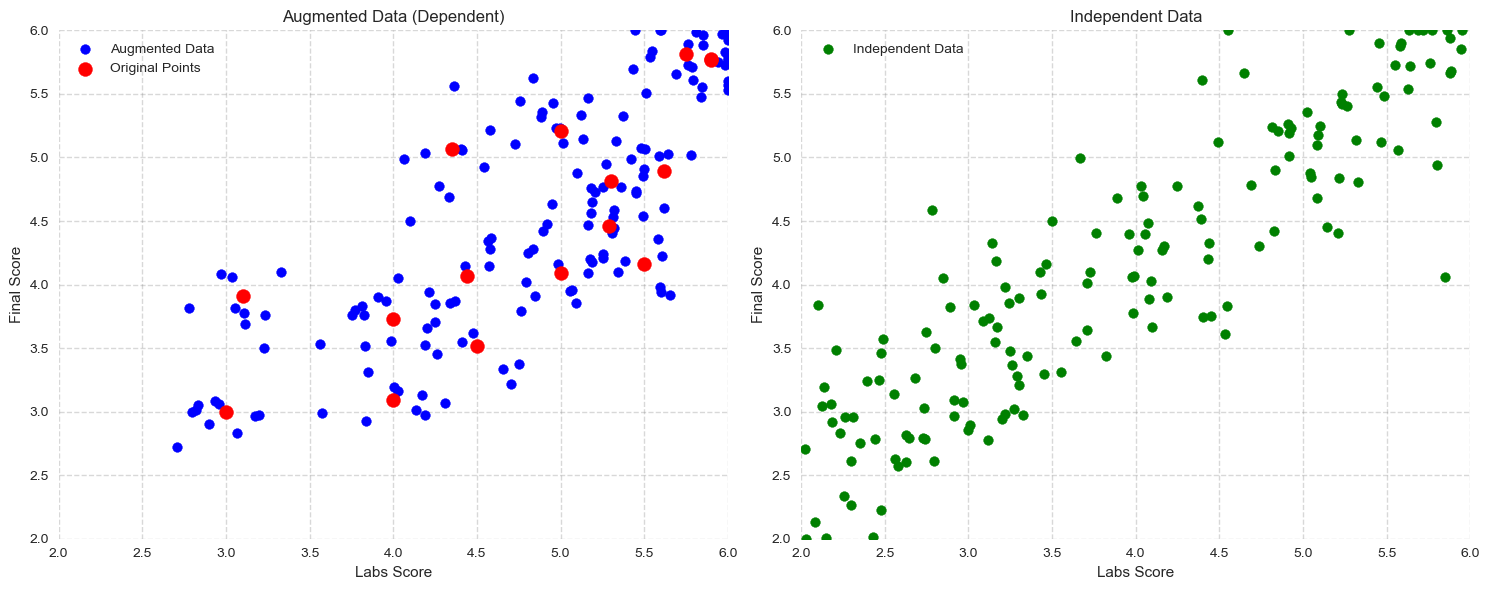

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Original data
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create augmented data
np.random.seed(42)
augmented = []
for i in range(len(df)):
    row = df.iloc[i]
    for _ in range(10):
        noise = np.random.normal(0, 0.2, 3)
        new_row = row + noise
        new_row = new_row.clip(2, 6)
        augmented.append(new_row)

df_aug = pd.DataFrame(augmented, columns=df.columns)

# Generate independent data
np.random.seed(42)
n_points = len(df_aug)
labs_independent = np.random.uniform(2, 6, n_points)
noise = np.random.normal(0, 0.5, n_points)
final_independent = np.clip(labs_independent * 0.8 + noise + 1, 2, 6)

# Create figure with white background
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax2.set_facecolor('white')

# Plot augmented data
ax1.scatter(df_aug['Labs'], df_aug['Final'],  color='blue', label='Augmented Data')
ax1.scatter(df['Labs'], df['Final'], color='red', s=100,  label='Original Points')
ax1.set_title('Augmented Data (Dependent)')
ax1.set_xlabel('Labs Score')
ax1.set_ylabel('Final Score')
ax1.grid(True, alpha=0.3, color='gray', linestyle='--')
ax1.set_xlim(2, 6)
ax1.set_ylim(2, 6)
ax1.legend()

# Plot independent data
ax2.scatter(labs_independent, final_independent,  color='green', label='Independent Data')
ax2.set_title('Independent Data')
ax2.set_xlabel('Labs Score')
ax2.set_ylabel('Final Score')
ax2.grid(True, alpha=0.3, color='gray', linestyle='--')
ax2.set_xlim(2, 6)
ax2.set_ylim(2, 6)
ax2.legend()

plt.tight_layout()
plt.show()


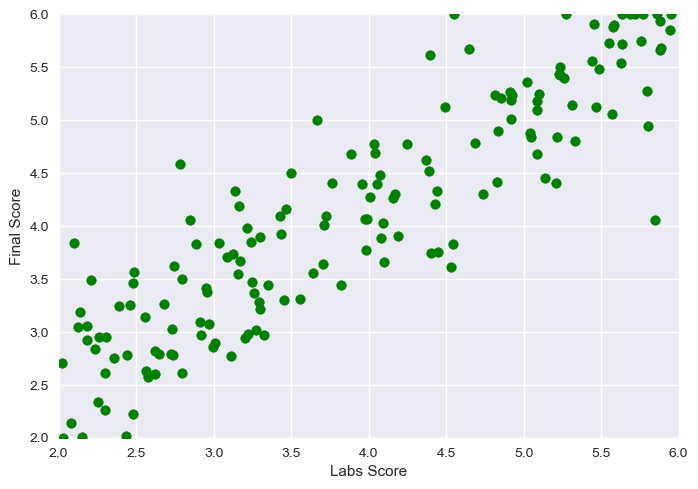

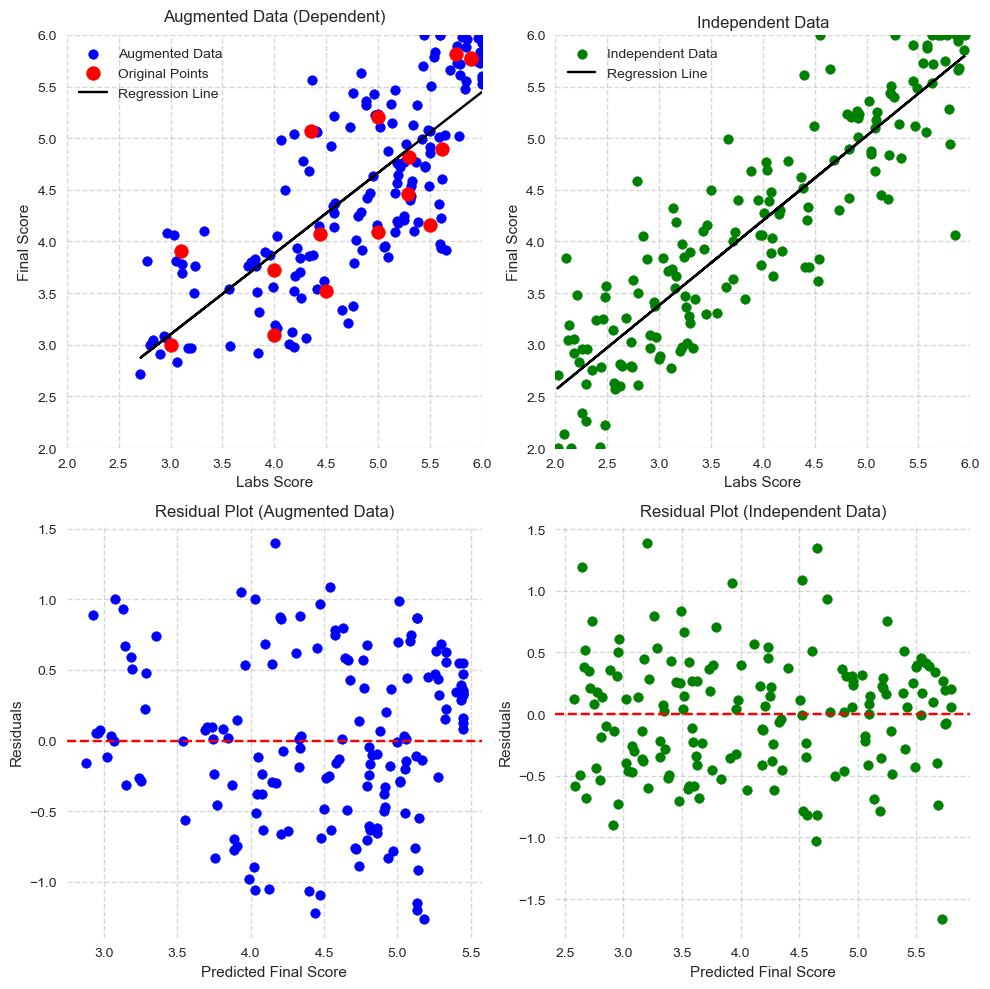


Regression Statistics:
Augmented Data R² score: 0.5929169115838182
Independent Data R² score: 0.8014636745280083


In [35]:
from sklearn.linear_model import LinearRegression
# Fit linear regression and get residuals for augmented data
reg_aug = LinearRegression()
X_aug = df_aug['Labs'].values.reshape(-1, 1)
y_aug = df_aug['Final'].values
reg_aug.fit(X_aug, y_aug)
y_pred_aug = reg_aug.predict(X_aug)
residuals_aug = y_aug - y_pred_aug

# Fit linear regression and get residuals for independent data
reg_ind = LinearRegression()
X_ind = labs_independent.reshape(-1, 1)
reg_ind.fit(X_ind, final_independent)
y_pred_ind = reg_ind.predict(X_ind)
residuals_ind = final_independent - y_pred_ind


#plot raw data that are artificially created but nicely linear

plt.figure()
plt.scatter(labs_independent, final_independent, alpha=1, color='green')
plt.xlabel('Labs Score')
plt.ylabel('Final Score')
plt.xlim(2, 6)
plt.ylim(2, 6)

plt.show()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.patch.set_facecolor('white')
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_facecolor('white')

#  augmented data and regression line
ax1.scatter(df_aug['Labs'], df_aug['Final'], alpha=1, color='blue', label='Augmented Data')
ax1.scatter(df['Labs'], df['Final'], color='red', s=100, alpha=1, label='Original Points')
ax1.plot(X_aug, y_pred_aug, color='black', linestyle='-', label='Regression Line')
ax1.set_title('Augmented Data (Dependent)', pad=10)
ax1.set_xlabel('Labs Score')
ax1.set_ylabel('Final Score')
ax1.grid(True, alpha=0.3, color='gray', linestyle='--')
ax1.set_xlim(2, 6)
ax1.set_ylim(2, 6)
ax1.legend()

#  independent data and regression line
ax2.scatter(labs_independent, final_independent, alpha=1, color='green', label='Independent Data')
ax2.plot(X_ind, y_pred_ind, color='black', linestyle='-', label='Regression Line')
ax2.set_title('Independent Data')
ax2.set_xlabel('Labs Score')
ax2.set_ylabel('Final Score')
ax2.grid(True, alpha=0.3, color='gray', linestyle='--')
ax2.set_xlim(2, 6)
ax2.set_ylim(2, 6)
ax2.legend()

#  independent data and no regression line
#ax3.scatter(labs_independent, final_independent, alpha=1, color='green', label='Final')
#ax3.set_title('Independent Data')
#ax3.set_xlabel('Labs Score')
#ax3.set_ylabel('Final Score')
#ax3.grid(True, alpha=0.3, color='gray', linestyle='--')
#ax3.set_xlim(2, 6)
#ax3.set_ylim(2, 6)
#ax3.legend()

#  residuals for augmented data
ax3.scatter(y_pred_aug, residuals_aug, alpha=1, color='blue')
ax3.axhline(y=0, color='red', linestyle='--')
ax3.set_title('Residual Plot (Augmented Data)')
ax3.set_xlabel('Predicted Final Score')
ax3.set_ylabel('Residuals')
ax3.grid(True, alpha=0.3, color='gray', linestyle='--')

# residuals for independent data
ax4.scatter(y_pred_ind, residuals_ind, alpha=1, color='green')
ax4.axhline(y=0, color='red', linestyle='--')
ax4.set_title('Residual Plot (Independent Data)')
ax4.set_xlabel('Predicted Final Score')
ax4.set_ylabel('Residuals')
ax4.grid(True, alpha=0.3, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

# Print regression statistics
print("\nRegression Statistics:")
print("Augmented Data R² score:", reg_aug.score(X_aug, y_aug))
print("Independent Data R² score:", reg_ind.score(X_ind, final_independent))

Regression task with clusters

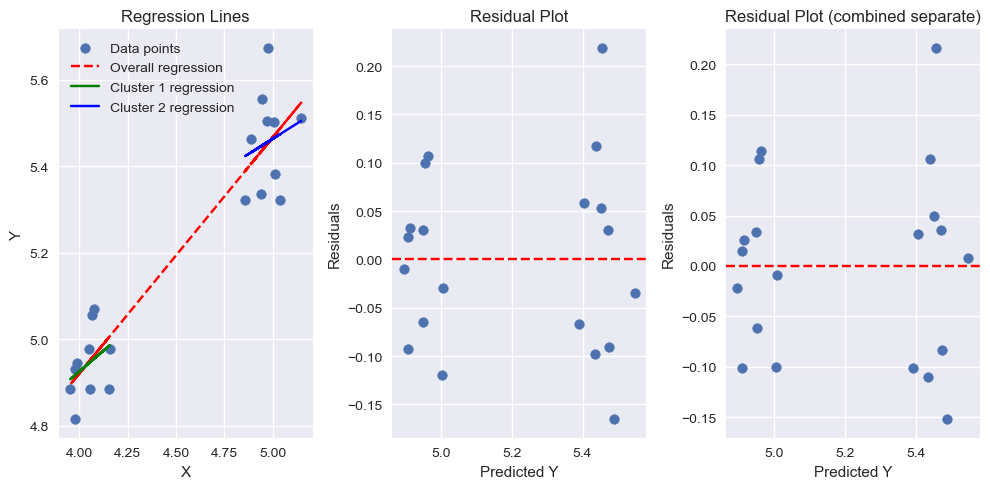

Sum of squared residuals (overall): 0.171442
Sum of squared residuals (within clusters): 0.165919
Ratio (overall/within): 1.03


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Generates two clusters of points
np.random.seed(42)
# Cluster 1
x1 = np.random.normal(4, 0.1, 10)
y1 = 3 + 0.5*x1 + np.random.normal(0, 0.1, 10)

# Cluster 2
x2 = np.random.normal(5, 0.1, 10)
y2 = 3 + 0.5*x2 + np.random.normal(0, 0.1, 10)

# Combines points
X = np.concatenate([x1, x2]).reshape(-1, 1)
y = np.concatenate([y1, y2])

# Overall regression
reg_all = LinearRegression()
reg_all.fit(X, y)
y_pred_all = reg_all.predict(X)
residuals_all = y - y_pred_all

# Separates regressions for each cluster
reg1 = LinearRegression()
reg1.fit(x1.reshape(-1, 1), y1)
y_pred1 = reg1.predict(x1.reshape(-1, 1))
residuals1 = y1 - y_pred1

reg2 = LinearRegression()
reg2.fit(x2.reshape(-1, 1), y2)
y_pred2 = reg2.predict(x2.reshape(-1, 1))
residuals2 = y2 - y_pred2

# Calculates sum of squared residuals
ssr_all = np.sum(residuals_all**2)
ssr_clusters = np.sum(residuals1**2) + np.sum(residuals2**2)


plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.scatter(X, y, alpha=1, label='Data points')
plt.plot(X, y_pred_all, 'r--', label='Overall regression')
plt.plot(x1, y_pred1, 'g-', label='Cluster 1 regression')
plt.plot(x2, y_pred2, 'b-', label='Cluster 2 regression')
plt.title('Regression Lines')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.subplot(132)
plt.scatter(y_pred_all, residuals_all, alpha=1)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Y')
plt.ylabel('Residuals')

plt.subplot(133)
plt.scatter(y_pred_all, [residuals1, residuals2], alpha=1)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot (combined separate)')
plt.xlabel('Predicted Y')
plt.ylabel('Residuals')


plt.tight_layout()
plt.show()

print(f"Sum of squared residuals (overall): {ssr_all:.6f}")
print(f"Sum of squared residuals (within clusters): {ssr_clusters:.6f}")
print(f"Ratio (overall/within): {ssr_all/ssr_clusters:.2f}")

**Coefficient of determination**

(0.0, 1.0, 0.0, 1.0)

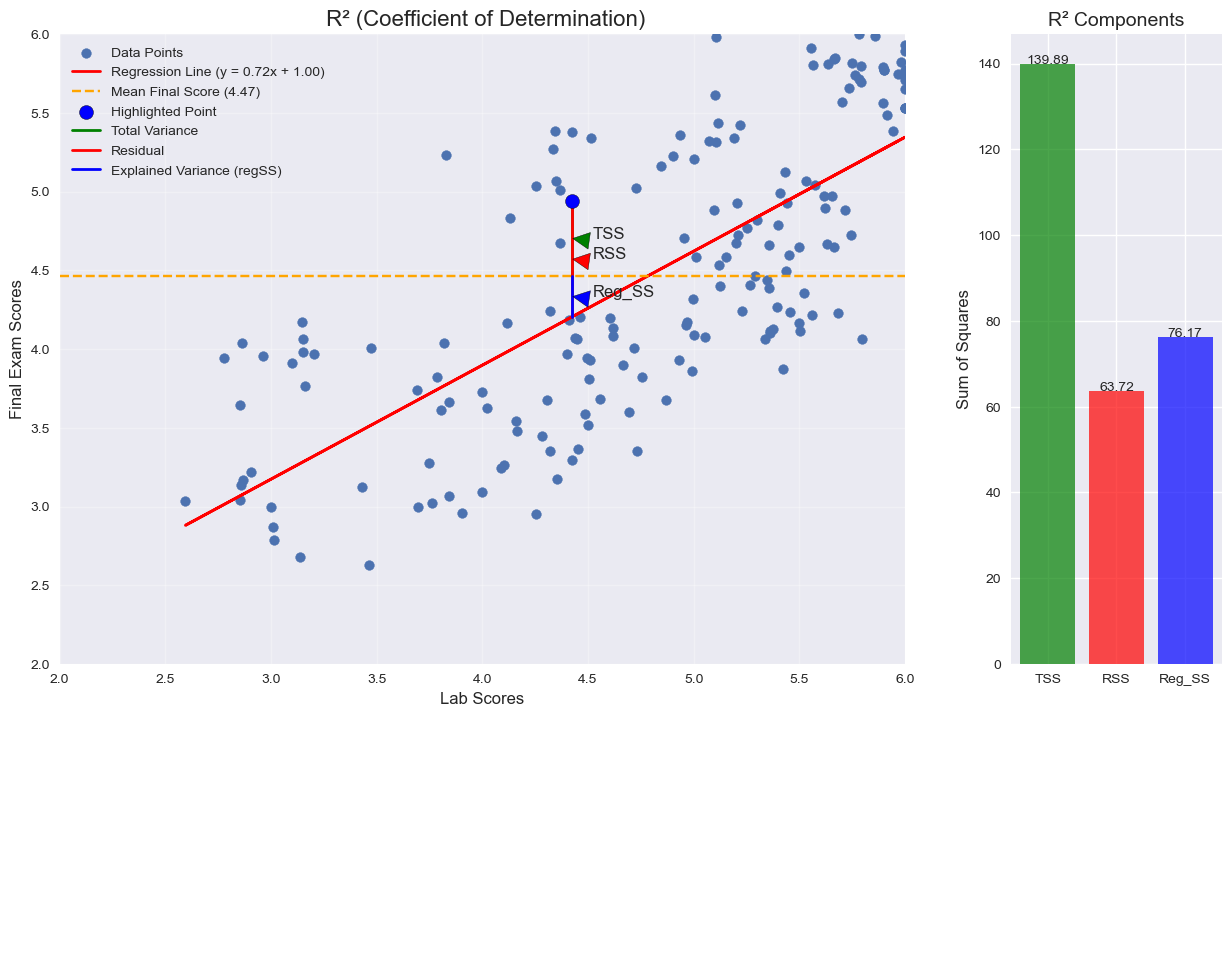

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Rectangle, FancyArrowPatch
import matplotlib.gridspec as gridspec

# Set the data
data = {
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}
df = pd.DataFrame(data)

# Augment data
np.random.seed(42)
augmented = []
for i in range(len(df)):
    row = df.iloc[i]
    for _ in range(10):
        noise = np.random.normal(0, 0.2, 2)
        new_row = row + noise
        new_row = new_row.clip(2, 6)
        augmented.append(new_row)
df_aug = pd.DataFrame(augmented, columns=df.columns)

# Add original data points
df_aug = pd.concat([df, df_aug])

# Create the regression model
X = df_aug['Labs'].values.reshape(-1, 1)
y = df_aug['Final'].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Calculate various components
mean_y = np.mean(y)
total_ss = np.sum((y - mean_y) ** 2)
residual_ss = np.sum((y - y_pred) ** 2)
regression_ss = total_ss - residual_ss
r_squared = 1 - (residual_ss / total_ss)

# Create figure with gridspec for subplots
plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[4, 1])

# Main scatter plot in top left
ax_main = plt.subplot(gs[0, 0])
ax_main.scatter(X, y, alpha=1, label='Data Points')
ax_main.plot(X, y_pred, color='red', linewidth=2, label=f'Regression Line (y = {model.coef_[0]:.2f}x + {model.intercept_:.2f})')
ax_main.axhline(y=mean_y, color='orange', linestyle='--', label=f'Mean Final Score ({mean_y:.2f})')

# Highlight a specific point to demonstrate components
highlight_idx = 50  # Select a point to highlight
x_highlight = X[highlight_idx]
y_highlight = y[highlight_idx]
y_pred_highlight = y_pred[highlight_idx]

# Plot the point
ax_main.scatter(x_highlight, y_highlight, color='blue', s=100, edgecolor='black', zorder=5, label='Highlighted Point')

# Plot the total variance line
ax_main.plot([x_highlight, x_highlight], [y_highlight, mean_y], color='green', linestyle='-', linewidth=2, label='Total Variance')

# Plot the residual line
ax_main.plot([x_highlight, x_highlight], [y_highlight, y_pred_highlight], color='red', linestyle='-', linewidth=2, label='Residual')

# Plot the explained variance line
ax_main.plot([x_highlight, x_highlight], [y_pred_highlight, mean_y], color='blue', linestyle='-', linewidth=2, label='Explained Variance (regSS)')

# Annotations
ax_main.annotate('TSS', xy=(x_highlight[0], (y_highlight + mean_y)/2), xytext=(x_highlight[0]+0.1, (y_highlight + mean_y)/2),
            arrowprops=dict(facecolor='green', shrink=0.05), fontsize=12)

ax_main.annotate('RSS', xy=(x_highlight[0], (y_highlight + y_pred_highlight)/2), xytext=(x_highlight[0]+0.1, (y_highlight + y_pred_highlight)/2),
            arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12)

ax_main.annotate('Reg_SS', xy=(x_highlight[0], (y_pred_highlight + mean_y)/2), xytext=(x_highlight[0]+0.1, (y_pred_highlight + mean_y)/2),
            arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=12)

ax_main.set_xlabel('Lab Scores', fontsize=12)
ax_main.set_ylabel('Final Exam Scores', fontsize=12)
ax_main.set_xlim(2, 6)
ax_main.set_ylim(2, 6)
ax_main.set_title(' R² (Coefficient of Determination)', fontsize=16)
ax_main.legend(loc='upper left')
ax_main.grid(True, alpha=0.3)

# R² Component Visualization 
ax_r2 = plt.subplot(gs[0, 1])
components = ['TSS', 'RSS', 'Reg_SS']
values = [total_ss, residual_ss, regression_ss]
colors = ['green', 'red', 'blue']

#  bar chart for TSS components
ax_r2.bar(components, values, color=colors, alpha=0.7)
ax_r2.set_title('R² Components', fontsize=14)
ax_r2.set_ylabel('Sum of Squares', fontsize=12)
for i, v in enumerate(values):
    ax_r2.text(i, v + 0.1, f'{v:.2f}', ha='center', fontsize=10)

#including the calculation numbers in the text
explanation = f"""
R² Coefficient of Determination Explanation:

• Formula: R² = 1 - (RSS/TSS) = 1 - ({residual_ss:.2f}/{total_ss:.2f}) = {r_squared:.4f}

• Components:
  - TSS (Total Sum of Squares): {total_ss:.2f}
    The total variance in the data, calculated as Σ(y_i - ȳ)²
    This measures how spread out the Final scores are from their mean.
    
  - RSS (Residual Sum of Squares): {residual_ss:.2f}
    The unexplained variance, calculated as Σ(y_i - ŷ_i)²
    This represents the error in our predictions with the regression model.
    
  - ESS (Explained Sum of Squares): {regression_ss:.2f}
    The variance explained by the model, calculated as TSS - RSS
    
• Interpretation:
  - R² of {r_squared:.4f} means that {r_squared*100:.2f}% of the variation in Final Exam scores
    can be explained by the Lab Scores.
  - The remaining {(1-r_squared)*100:.2f}% is due to other factors not captured by the model.
"""



ax_text = plt.subplot(gs[1, :])
ax_text.axis('off')